# Морфология
В этом ноутбуке описана подготовка данных для задачи POS-tagging. А также пара простых моделей на keras, решающих данную задачу. Оригинальная задача и ноутбук есть в контесте: https://www.kaggle.com/c/rupos2018/overview

In [1]:
! nvidia-smi

Mon Mar 13 18:05:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:06.0 Off |                    0 |
| N/A   24C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Часть 1. Загрузка корпуса
Здесь мы прочитаем корпуса из csv и разложим их по спискам.

In [2]:
# для совместимости со вторым питоном
from __future__ import print_function
import io

In [28]:
from tqdm.notebook import tqdm

In [3]:
# Имена файлов с данными.
TRAIN_FILENAME = "../data/morphology/train.csv"
TEST_FILENAME = "../data/morphology/test.csv"

In [17]:
! head "../data/morphology/train.csv" --lines=10

Id	LocalNum	Word	Prediction
0	1	А	CONJ#_
1	2	ведь	PART#_
2	3	для	ADP#_
3	4	конкретных	ADJ#Case=Gen|Degree=Pos|Number=Plur
4	5	изделий	NOUN#Animacy=Inan|Case=Gen|Gender=Neut|Number=Plur
5	6	зачастую	ADV#Degree=Pos
6	7	нужен	ADJ#Degree=Pos|Gender=Masc|Number=Sing|Variant=Brev
7	8	монокристалл	NOUN#Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing
8	9	не	PART#_


In [18]:
! head "../data/morphology/test.csv" --lines=10

Id	LocalNum	Word
0	1	Да
1	2	,
2	3	по
3	4	количеству
4	5	студентов
5	6	мы
6	7	превосходим
7	8	все
8	9	страны


In [4]:
# Считывание файлов.
from collections import namedtuple
WordForm = namedtuple("WordForm", "word pos gram")

def get_sentences(filename, is_train):
    sentences = []
    with io.open(filename, "r", encoding='utf-8') as r:
        # Пропускаем заголовок
        next(r)
        sentence = [] # будем заполнять список предложений
        for line in r:
            # предложения отделены по '\n'
            if len(line.strip()) == 0:
                if len(sentence) == 0:
                    continue
                sentences.append(sentence)
                sentence = []
                continue
            if is_train:
                # Формат: индекс\tномер_в_предложении\tсловоформа\tPOS#Грамемы
                word = line.strip().split("\t")[2]
                pos = line.strip().split("\t")[3].split("#")[0]
                gram = line.strip().split("\t")[3].split("#")[1]
                sentence.append(WordForm(word, pos, gram))
            else:
                word = line.strip().split("\t")[2]
                sentence.append(word)
        if len(sentence) != 0:
            sentences.append(sentence)
    return sentences

In [5]:
train = get_sentences(TRAIN_FILENAME, True)
test = get_sentences(TEST_FILENAME, False)

In [6]:
# Выыедем, что получилось
for wordform in train[0][:10]:
    print(wordform.word, '\t', wordform.pos, '\t', wordform.gram)

А 	 CONJ 	 _
ведь 	 PART 	 _
для 	 ADP 	 _
конкретных 	 ADJ 	 Case=Gen|Degree=Pos|Number=Plur
изделий 	 NOUN 	 Animacy=Inan|Case=Gen|Gender=Neut|Number=Plur
зачастую 	 ADV 	 Degree=Pos
нужен 	 ADJ 	 Degree=Pos|Gender=Masc|Number=Sing|Variant=Brev
монокристалл 	 NOUN 	 Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing
не 	 PART 	 _
только 	 PART 	 _


In [20]:
train[0][:5]

[WordForm(word='А', pos='CONJ', gram='_'),
 WordForm(word='ведь', pos='PART', gram='_'),
 WordForm(word='для', pos='ADP', gram='_'),
 WordForm(word='конкретных', pos='ADJ', gram='Case=Gen|Degree=Pos|Number=Plur'),
 WordForm(word='изделий', pos='NOUN', gram='Animacy=Inan|Case=Gen|Gender=Neut|Number=Plur')]

Для простоты далее будем использовать токены слов и POS-теги. Но чтобы определять грамматические значения нужно еще провести некоторые манипуляции с данными, описанные в оригинальном ноутубке. Мы же ограничимся только определением частей речи

## Часть 2. Подготовка эмбеддингов

Обычно в качестве признаков для обучения сеток используются словные эмбеддинги. Для этого можно скачать предобученные и сохранить их в матрицу, где в расположатся векторы эмбеддингах по индексам, соответсвующих слов

In [21]:
#запомним все уникальные слова и POS-теги в корпусе
word_set = set()
pos_set = set()
for sent in train:
    for wordform in sent:
        word_set.add(wordform.word.lower())
        pos_set.add(wordform.pos)

In [22]:
for word in list(word_set)[:10]: 
    print(word, end=', ')
print()
print(pos_set)

здании, мытарства, величайших, догнал, союзную, изобретать, виновны, джаищ-е-мухаммад, полнолицевой, комсомолец, 
{'ADV', 'CONJ', 'PROPN', 'ADP', 'PART', 'SCONJ', 'DET', 'VERB', 'AUX', 'PUNCT', 'ADJ', 'SYM', 'PRON', 'NUM', 'NOUN', 'INTJ', 'X'}


In [23]:
! wget https://nlp.stanford.edu/data/glove.6B.zip -O ../data/morphology/glove.6B.zip

--2023-03-13 19:12:42--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-13 19:12:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.12MB/s    in 2m 40s  

2023-03-13 19:15:24 (5.15 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

--2023-03-13 19:15:24--  http://../data/morphology/glove.6B.zip
Resolving .. (..)... failed: Name or service 

In [26]:
! unzip -d ../data/glove/ ../data/glove.6B.zip 

Archive:  ../data/glove.6B.zip
  inflating: ../data/glove/glove.6B.50d.txt  
  inflating: ../data/glove/glove.6B.100d.txt  
  inflating: ../data/glove/glove.6B.200d.txt  
  inflating: ../data/glove/glove.6B.300d.txt  


In [29]:
#Загрузите эмбеддинги c https://nlp.stanford.edu/projects/glove/ или другие, которые вам нравятся и пропишите путь к ним
import numpy as np

word_embeddings_path = '../data/glove/glove.6B.50d.txt'
word2idx = {}
word_embeddings = []
embedding_size = None

#Загружаем эмбеддинги
with io.open(word_embeddings_path, 'r', encoding="utf-8") as f_em:
    for line in tqdm(f_em):
        split = line.strip().split(" ")
        # Совсем короткие строки пропускаем
        if len(split) <= 2:
            continue
        # Встретив первую подходящую строку, фиксируем размер эмбеддингов
        if embedding_size is None:
            embedding_size = len(split) - 1
            # Также нициализируем эмбеддинги для паддингов и неизвестных слов
            word2idx["PADDING_TOKEN"] = len(word2idx)
            word_embeddings.append(np.zeros(embedding_size))

            word2idx["UNKNOWN_TOKEN"] = len(word2idx)
            word_embeddings.append(np.random.uniform(-0.25, 0.25, embedding_size))
        # После этого все эмбеддинги должны быть одинаковой длины
        if len(split) - 1 != embedding_size:
            continue
            
        #Если слова нет в корпусе, то не будем для него запоминать эмбеддинг        
        if (split[0] not in word_set):
            continue
        
        word_embeddings.append(np.asarray(split[1:], dtype='float32'))
        word2idx[split[0]] = len(word2idx)

word_embeddings = np.array(word_embeddings, dtype='float32')

0it [00:00, ?it/s]

In [30]:
len(word_set & set(word2idx.keys()))

1948

In [31]:
len(word_set)

98880

Как-то эмбеддинги не сильно подходят для данного корпуса поэтому, просто инициализируем рандмно матрицу эмбеддингов при определении сетки. Вам же предлагается все-таки поискать подходящие эмбеддинги и использовать их при обучении.

## Часть 3. Подготовка данных
Теперь нам остается только пронумеровать все слова и POS-теги и можно переходить к обучению сеток.

In [32]:
word_to_index = {'PAD' : 0, 'UNK' : 1}
for word in word_set:
    word_to_index[word] = len(word_to_index)

In [33]:
pos_to_index = {}
index_to_pos = {}
for pos in pos_set:
    pos_to_index[pos] = len(pos_to_index)
    index_to_pos[len(index_to_pos)] = pos

In [34]:
# для полносвязной сетки просто захреначим все в один список
data_X = []
data_Y = []
for sent in train:
    for wordform in sent:
        data_X.append(word_to_index[wordform.word.lower()])
        data_Y.append(pos_to_index[wordform.pos])

In [35]:
print(data_X[:10])
print(data_Y[:10])

[6543, 28464, 91923, 11124, 44299, 96103, 13283, 50177, 29849, 17278]
[1, 4, 3, 10, 14, 0, 10, 14, 4, 4]


## Часть 4. Полносвязная сеть
Самой простой моделью является обычный перцептрон. На вход сетки будем подавать просто эмдеддинг каждого слова, на выходе ожидать распредедение вероятностей по тегам. В качестве фреймворка достаточно будет использовать keras и его Sequential модель (https://keras.io/models/sequential/), в которую слои добавляются последовательно, с помощью метода `add`.

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Activation, Flatten

In [38]:
model = Sequential()
# на самом деле на вход сетки будет добавляться индекс слова, а слой эмбеддинга будет возвращать для него вектор
model.add(Embedding(input_length=1, input_dim=len(word_to_index), output_dim=50, embeddings_initializer='random_uniform',
                    trainable=False)) # матрицу эмбеддингов просто инициализируем нормальным распределением и отключим обучение
# далее нам нужно схлопнуть трехмерный тензор с одной фиктивной размерностью в двумерный
model.add(Flatten())
model.add(Dense(100)) # основной полносвязный слой
model.add(Activation('relu')) # для приличия добавим функцию активации
model.add(Dense(len(pos_to_index))) # выходной слой тоже полносвязный размерности по кол-ву тегов
model.add(Activation('softmax')) # ну и в конце делаем softmax, чтобы получить распределение
model.summary() # вывод получившейся модели

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 50)             4944100   
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               5100      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                1717      
_________________________________________________________________
activation_1 (Activation)    (None, 17)                0         
Total params: 4,950,917
Trainable params: 6,817
Non-trainable params: 4,944,100
__________________________________________

In [41]:
# компилируем модель
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
# и обучаем
model.fit(np.array(data_X), np.array(data_Y), epochs=1, batch_size=256, 
          workers=4, use_multiprocessing=True)

3324/3324 [==============================] - 8s 2ms/step - loss: 1.4174 - accuracy: 0.5453


Проверка обученности модели остается за вами. Этот пример лишь для того, чтобы показать как собрать сетку и скормить ей данные.

## Часть 5. Рекуррентая сеть.

Далее рассмотрим более приближенную к SOTA модель. Ей является рекуррентая сеть, которая принимает эмбеддинги слов в предложении и генерирует для них распределение вероятностей. Основным отличием от прошлой в том, что теперь мы будем использовать соседние слова как раз за счет рекуррентого слоя. Для этой модели мы уже будем использовать функциональный способ задания модели все того же кераса (https://keras.io/models/model/).

In [43]:
from tensorflow.keras.layers import LSTM, TimeDistributed, Bidirectional, Input
from tensorflow.keras.models import Model

In [44]:
# В начале задается входной слой, в котором мы укажем входную размерность. 
# Это будет None, т.к. мы заранее не знаем, какой будет длина каждого предложения 
input_layer = Input(shape=(None,), name='input')
# Далее идет все тот же слой эмеддинга, которому мы на вход подаем предыдущий слой (в этом и суть functional APO)
embeddings_layer = Embedding(input_dim=len(word_to_index), output_dim=50, 
                             trainable=False, embeddings_initializer='random_uniform',
                             name='embedding')(input_layer)
# Итак, основным слоем здесь будет двусторонний LSTM, который будет возвращать вектор для каждого слова (return_sequences=True) 
blstm_layer = Bidirectional(LSTM(100, return_sequences=True), name='blstm')(embeddings_layer)
# Аналогично т.к. у нас здесь вектора для каждого слоя, то и полносвязный слой должен применяться для каждого слоя 
# по-отдельности. Поэтому полносвязный слой оборачивается в  TimeDistributed
result_layer = TimeDistributed(Dense(len(pos_to_index), activation='softmax', name='result'))(blstm_layer)
# собственно определяем модель входными и выходными слоями
model = Model(inputs=[input_layer], outputs=result_layer)
# компилируем
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# выводим архитектуру
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 50)          4944100   
_________________________________________________________________
blstm (Bidirectional)        (None, None, 200)         120800    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 17)          3417      
Total params: 5,068,317
Trainable params: 124,217
Non-trainable params: 4,944,100
_________________________________________________________________


Далее нам нужно было бы распределить слова по предложениям, распределить по группам по длине, выравнить предложения по длине в одной групе, заполнив недостающие слова паддингами. Но это довольно неприятный процесс, а мне просто хочется запустить сетку и проверить, что она вообще работает, что сошлись все разверности. Поэтому просто раскидаем по 10 слов с помощью `numpy.reshape`

In [45]:
rnnX = np.reshape(data_X[:850000], (-1,10))
rnnY = np.reshape(data_Y[:850000], (-1,10,1))

In [46]:
np.shape(rnnX)

(85000, 10)

Ну и проверим, что оно вообще работает.

In [47]:
model.fit(rnnX, rnnY, epochs=1, batch_size=256)

333/333 [==============================] - 7s 6ms/step - loss: 2.1057 - accuracy: 0.3465


## Часть 6. Задание
В качестве упражения предлагается довести до ума обучения второй модели: распределить слова по предложениям, написать тестирование модели и собственно посмотреть как оно обучилось. Тестировать предлагаю на последней 1000 предложений, обучать - на остальном. Кто уверен в своих желаниях, то может решить оригинальную задачу: предсказывать также грамматические категории. 

In [54]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [52]:
len(data_X)

850689

In [57]:
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(rnnX, rnnY, test_size=TEST_SIZE, random_state=42)

In [58]:
VALID_SIZE = 0.15
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=42)

In [59]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (61412, 10)
Shape of output sequences: (61412, 10, 1)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (10838, 10)
Shape of output sequences: (10838, 10, 1)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (12750, 10)
Shape of output sequences: (12750, 10, 1)


In [63]:
model_trained = model.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data=(X_val, Y_val))

Epoch 1/10
240/240 [==============================] - 2s 7ms/step - loss: 1.1778 - accuracy: 0.6045 - val_loss: 1.1756 - val_accuracy: 0.6046
Epoch 2/10
240/240 [==============================] - 2s 7ms/step - loss: 1.1573 - accuracy: 0.6090 - val_loss: 1.1548 - val_accuracy: 0.6085
Epoch 3/10
240/240 [==============================] - 2s 7ms/step - loss: 1.1365 - accuracy: 0.6151 - val_loss: 1.1348 - val_accuracy: 0.6141
Epoch 4/10
240/240 [==============================] - 2s 7ms/step - loss: 1.1151 - accuracy: 0.6211 - val_loss: 1.1143 - val_accuracy: 0.6218
Epoch 5/10
240/240 [==============================] - 2s 7ms/step - loss: 1.0943 - accuracy: 0.6274 - val_loss: 1.0938 - val_accuracy: 0.6274
Epoch 6/10
240/240 [==============================] - 2s 7ms/step - loss: 1.0747 - accuracy: 0.6332 - val_loss: 1.0785 - val_accuracy: 0.6342
Epoch 7/10
240/240 [==============================] - 2s 7ms/step - loss: 1.0556 - accuracy: 0.6383 - val_loss: 1.0574 - val_accuracy: 0.6383
Epoch 

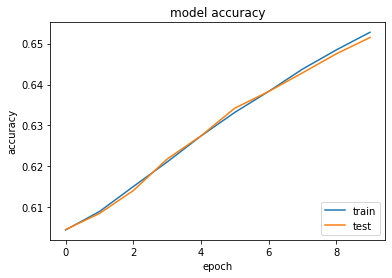

In [66]:
plt.plot(model_trained.history['accuracy'])
plt.plot(model_trained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()